# ***Importing Packages***

In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import seaborn as sns
import re 
from scipy import stats
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score , RandomizedSearchCV , cross_validate , GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer , mean_absolute_error , r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import uniform, loguniform

# ***Importing data***

In [517]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data = pd.read_csv(r"cars dataset.csv")

# ***Assessing data***

In [518]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,5.0


In [519]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7528 entries, 0 to 7527
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           7528 non-null   object 
 1   year           7528 non-null   int64  
 2   selling_price  7528 non-null   int64  
 3   km_driven      7528 non-null   int64  
 4   fuel           7528 non-null   object 
 5   seller_type    7528 non-null   object 
 6   transmission   7528 non-null   object 
 7   owner          7528 non-null   object 
 8   mileage        7309 non-null   object 
 9   engine         7309 non-null   object 
 10  max_power      7315 non-null   object 
 11  seats          7309 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 705.9+ KB


In [520]:
data.describe()

,year,selling_price,km_driven,seats
count,7528.000000,7.528000e+03,7.528000e+03,7309.000000
mean,2013.529756,4.525882e+05,7.249344e+04,5.407443
std,4.046582,2.580495e+05,5.725892e+04,0.959685
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.500000e+05,3.700000e+04,5.000000
50%,2014.000000,4.150000e+05,6.659350e+04,5.000000
75%,2017.000000,6.250000e+05,1.000000e+05,5.000000
max,2020.000000,1.300000e+06,2.360457e+06,14.000000


## Preprocessing steps

* Handling missing values in mileage, engine, max_power, torque and seats
* Extracting values out of mileage, engine, max_power and torque
* converting columns data types

### 1- Handling missing values

In [521]:
data.shape

(7528, 12)

In [522]:
data_copy = data.copy()

In [523]:
nulls_ratio = data_copy["mileage"].isnull().mean() * 100
print(f"Null ratio = {nulls_ratio}")

Null ratio = 2.9091392136025505


Considering that the null values constitute a small proportion of the dataset, I have decided to remove them.

In [524]:
# removing rows containing nulls in the torque column
data_copy = data_copy[~data_copy["mileage"].isnull()]

In [525]:
data_copy.isnull().mean()

name             0.0
year             0.0
selling_price    0.0
km_driven        0.0
fuel             0.0
seller_type      0.0
transmission     0.0
owner            0.0
mileage          0.0
engine           0.0
max_power        0.0
seats            0.0
dtype: float64

### 2- Values extraction

In [526]:
data_copy[["mileage" , "mileage unit"]] = data_copy["mileage"].str.split(" ", expand=True)
data_copy["mileage unit"].unique()

array(['kmpl', 'km/kg'], dtype=object)

In [527]:
data_copy["fuel"].unique()

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

The conversion from km/kg to kmpl necessitates knowledge of the specific density of the fuel employed, as the conversion factor varies based on the type of fuel.

* Diesel: to convert from km/kg to kmpl for diesel fuel, divide the value in km/kg by 0.832

* Petrol (Gasoline):Divide the value in km/kg by 0.74 to convert from km/kg to kmpl for petrol fuel

* LPG (Liquefied Petroleum Gas):Divide the value in km/kg by 0.54 to convert from km/kg to kmpl for LPG fuel.

* CNG (Compressed Natural Gas): Divide the value in km/kg by 0.128 to convert from km/kg to kmpl for CNG fuel.

In [528]:
# converting mileage column datatype into int 
data_copy['mileage'] = data_copy['mileage'].astype(float)

In [529]:
# converting mileage into kpml mileage
data_copy.loc[(data_copy['fuel'] == "Diesel") & (data_copy['mileage unit'] == "km/kg"), 'kpml mileage'] = data_copy['mileage'] / 0.832
data_copy.loc[(data_copy['fuel'] == "Petrol") & (data_copy['mileage unit'] == "km/kg"), 'kpml mileage'] = data_copy['mileage'] / 0.74
data_copy.loc[(data_copy['fuel'] == "LPG") & (data_copy['mileage unit'] == "km/kg"), 'kpml mileage'] = data_copy['mileage'] / 0.54
data_copy.loc[(data_copy['fuel'] == "CNG") & (data_copy['mileage unit'] == "km/kg"), 'kpml mileage'] = data_copy['mileage'] / 0.128
data_copy.loc[data_copy['mileage unit'] == "kmpl", 'kpml mileage'] = data_copy['mileage']
data_copy.drop(["mileage" , "mileage unit"],axis=1,inplace= True)

In [530]:
data_copy.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,engine,max_power,seats,kpml mileage
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,1248 CC,74 bhp,5.0,23.40
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,1498 CC,103.52 bhp,5.0,21.14
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,1497 CC,78 bhp,5.0,17.70
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,1396 CC,90 bhp,5.0,23.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,1298 CC,88.2 bhp,5.0,16.10


Now let's do the same with the engine column

In [531]:
data_copy[["engine" , "engine unit"]] = data_copy["engine"].str.split(" ", expand=True)
data_copy["engine unit"].unique()

array(['CC'], dtype=object)

Since all the engines cubic capacity are expressed in cc then it's safe to rename the engine column

In [532]:
data_copy["engine in 'CC'"] = data_copy["engine"]
data_copy.drop(["engine" , "engine unit"],axis=1,inplace= True)

In [533]:
# extracting values out of the max_power column
data_copy[["max_power" , "max_power unit"]] = data_copy["max_power"].str.split(" ", expand=True)
data_copy["max_power unit"].unique()

array(['bhp'], dtype=object)

all the vehicles max_power are in "bhp" so it's fine to rename the max_power column

In [534]:
data_copy["bhb max_power"] = data_copy["max_power"]
data_copy.drop(["max_power" , "max_power unit"],axis=1,inplace= True)

In [535]:
data_copy.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,kpml mileage,engine in 'CC',bhb max_power
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,5.0,23.40,1248,74
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,5.0,21.14,1498,103.52
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,5.0,17.70,1497,78
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,5.0,23.00,1396,90
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,5.0,16.10,1298,88.2


### 3- Columns data types correction

In [536]:
data_copy["seats"] = data_copy["seats"].astype(int)
data_copy["engine in 'CC'"] = data_copy["engine in 'CC'"].astype(int)
data_copy["bhb max_power"] = data_copy["bhb max_power"].astype(float)
#data_copy["year"] = pd.to_datetime(data_copy["year"],format="%Y")

In [537]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7309 entries, 0 to 7527
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            7309 non-null   object 
 1   year            7309 non-null   int64  
 2   selling_price   7309 non-null   int64  
 3   km_driven       7309 non-null   int64  
 4   fuel            7309 non-null   object 
 5   seller_type     7309 non-null   object 
 6   transmission    7309 non-null   object 
 7   owner           7309 non-null   object 
 8   seats           7309 non-null   int32  
 9   kpml mileage    7309 non-null   float64
 10  engine in 'CC'  7309 non-null   int32  
 11  bhb max_power   7309 non-null   float64
dtypes: float64(2), int32(2), int64(3), object(5)
memory usage: 943.3+ KB


# ***Splitting Data*** 

In [538]:
training_data , testing_data = train_test_split(data_copy, test_size=.1,random_state=42)

# ***Exploring Data***

In [539]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6578 entries, 1722 to 7488
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            6578 non-null   object 
 1   year            6578 non-null   int64  
 2   selling_price   6578 non-null   int64  
 3   km_driven       6578 non-null   int64  
 4   fuel            6578 non-null   object 
 5   seller_type     6578 non-null   object 
 6   transmission    6578 non-null   object 
 7   owner           6578 non-null   object 
 8   seats           6578 non-null   int32  
 9   kpml mileage    6578 non-null   float64
 10  engine in 'CC'  6578 non-null   int32  
 11  bhb max_power   6578 non-null   float64
dtypes: float64(2), int32(2), int64(3), object(5)
memory usage: 616.7+ KB


In [540]:
training_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,kpml mileage,engine in 'CC',bhb max_power
1722,Maruti Ciaz S 1.3,2018,1000000,40000,Diesel,Individual,Manual,First Owner,5,28.09,1248,88.50
5845,Ford EcoSport 1.5 TDCi Titanium BSIV,2015,650000,110000,Diesel,Individual,Manual,Second Owner,5,22.77,1498,98.59
3057,Mahindra XUV500 W7 BSIV,2018,1100000,50000,Diesel,Individual,Manual,First Owner,7,15.10,2179,152.87
4440,Hyundai Grand i10 1.2 CRDi Sportz,2017,450000,56290,Diesel,Dealer,Manual,First Owner,5,24.00,1186,73.97
6221,Tata Indica V2 eLX,2014,200000,55896,Diesel,Individual,Manual,Second Owner,5,25.00,1396,69.00


In [541]:
# Select only the numerical columns
numerical_cols = training_data.select_dtypes(include=['datetime','float', 'int'])

# Calculate the correlation matrix
correlation_matrix = numerical_cols.corr()

# display correlation matrix
correlation_matrix

,year,selling_price,km_driven,seats,kpml mileage,engine in 'CC',bhb max_power
year,1.000000,0.628316,-0.393896,-0.008484,0.139387,-0.084670,0.099803
selling_price,0.628316,1.000000,-0.178396,0.240250,-0.033632,0.384347,0.566226
km_driven,-0.393896,-0.178396,1.000000,0.223187,-0.064220,0.301319,0.115615
seats,-0.008484,0.240250,0.223187,1.000000,-0.154447,0.675938,0.275672
kpml mileage,0.139387,-0.033632,-0.064220,-0.154447,1.000000,-0.203569,-0.172496
engine in 'CC',-0.084670,0.384347,0.301319,0.675938,-0.203569,1.000000,0.631715
bhb max_power,0.099803,0.566226,0.115615,0.275672,-0.172496,0.631715,1.000000


Based on the intial exploation it looks that the price has a moderate positive linear correlation with year and bhb max_power and a low linear correlation with  engine in 'CC'

<Axes: xlabel='bhb max_power', ylabel='selling_price'>

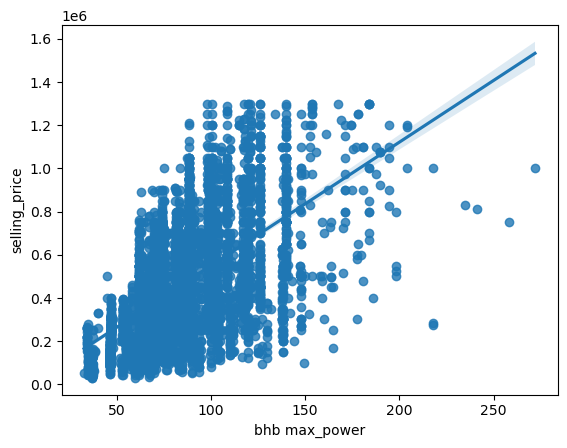

In [542]:
sns.regplot(x="bhb max_power",y="selling_price",data=training_data)

<Axes: xlabel="engine in 'CC'", ylabel='selling_price'>

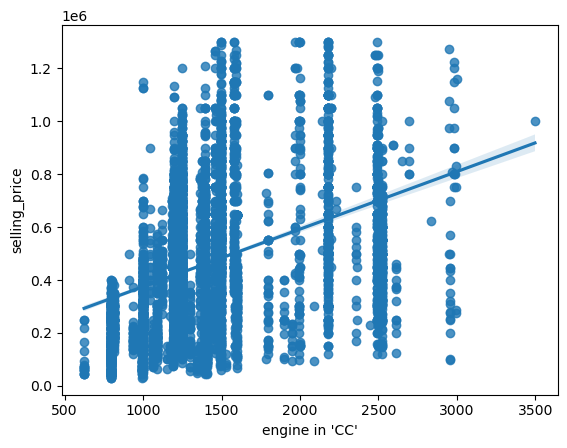

In [543]:
sns.regplot(x="engine in 'CC'",y="selling_price",data=training_data)

<Axes: xlabel='year', ylabel='selling_price'>

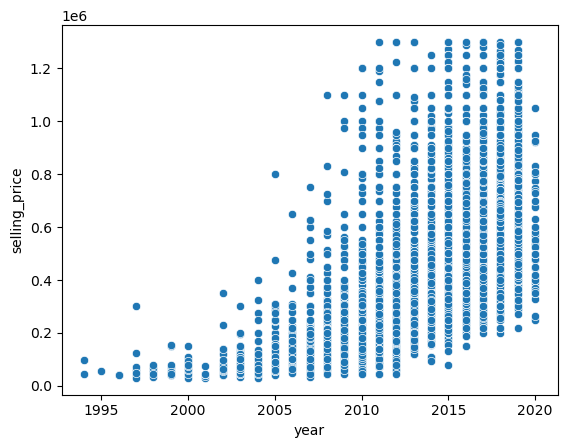

In [544]:
sns.scatterplot(x="year", y="selling_price", data=training_data)

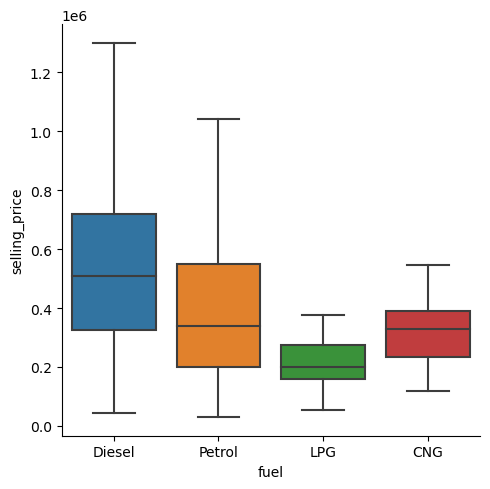

In [545]:
sns.catplot(x="fuel",y="selling_price",data=training_data,kind="box",sym="")

We see that the distributions of price between the different fuel types have a significant overlap, and so fuel types would not be a good predictor of price.

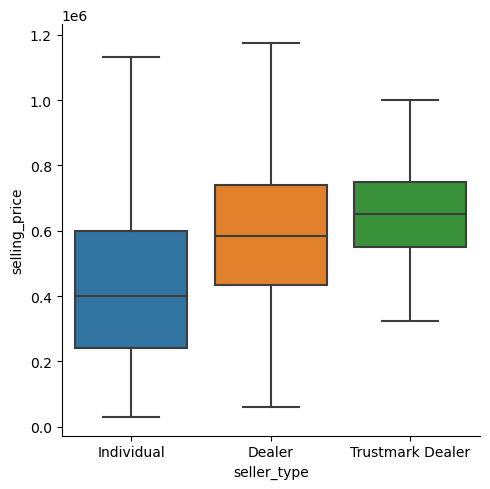

In [546]:
sns.catplot(x="seller_type",y="selling_price",data=training_data,kind="box",sym="")

The plot reveals that there is considerable overlap in the prices of vehicles sold by different types of sellers (seller_type). This observation implies that the seller_type may not provide meaningful insights or serve as a reliable predictor of price

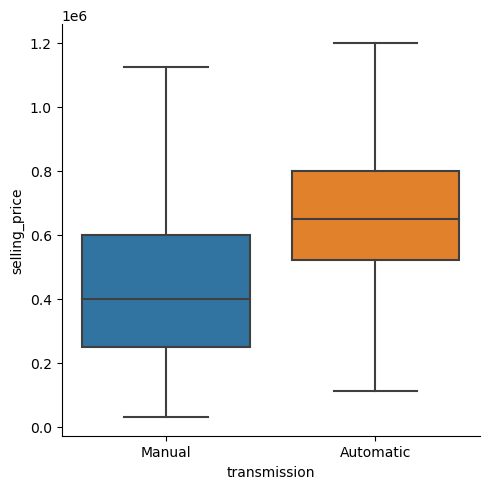

In [547]:
sns.catplot(x="transmission",y="selling_price",data=training_data,kind="box",sym="")

Here we see that the distribution of price between these two transmission categories, Manual and automatic, are distinct enough to take transmission as a potential good predictor of price.

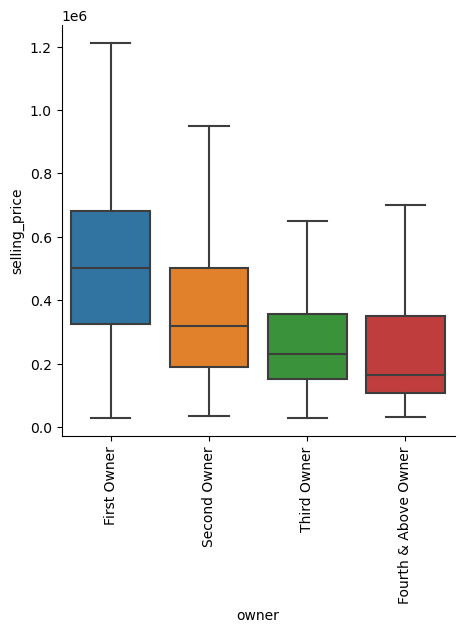

In [548]:
# Create the catplot
catplot = sns.catplot(x="owner", y="selling_price", data=training_data, kind="box", sym="")

# Customize the plot
catplot.set_xticklabels(rotation=90)  # Rotate x-axis labels by 45 degrees

The plot suggests that there is overlap in car prices among different owner types. This observation indicates that the owner variable may not have a significant impact on the car price.

## ***Descriptive Statistical Analysis***

In [549]:
training_data.describe()

,year,selling_price,km_driven,seats,kpml mileage,engine in 'CC',bhb max_power
count,6578.000000,6.578000e+03,6.578000e+03,6578.000000,6578.000000,6578.000000,6578.000000
mean,2013.710398,4.604599e+05,7.194213e+04,5.405746,21.020195,1393.792338,84.515318
std,3.864382,2.578996e+05,5.875600e+04,0.960214,15.773714,455.756426,25.535635
min,1994.000000,2.999900e+04,1.000000e+03,2.000000,0.000000,624.000000,32.800000
25%,2011.000000,2.500000e+05,3.500000e+04,5.000000,17.000000,1197.000000,68.000000
50%,2014.000000,4.250000e+05,6.490000e+04,5.000000,19.700000,1248.000000,81.830000
75%,2017.000000,6.250000e+05,1.000000e+05,5.000000,22.700000,1498.000000,98.600000
max,2020.000000,1.300000e+06,2.360457e+06,14.000000,261.250000,3498.000000,272.000000


## P-value:

What is this P-value? The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant.

By convention, when the

* the p-value is < 0.05 : it suggests that there is statistically significant evidence to reject the null hypothesis and conclude that there is a relationship between the variables being tested
* the p-value is > 0.05 : it suggests that there is not enough statistical evidence to reject the null hypothesis.

## Pearson Correlation

The Pearson Correlation measures the linear dependence between two variables X and Y.

The resulting coefficient is a value between -1 and 1 inclusive, where:

* 1: Total positive linear correlation.

* 0: No linear correlation, the two variables most likely do not affect each other.

* -1: Total negative linear correlation.

In [550]:
numerical_columns =  training_data.select_dtypes(include=['datetime','float', 'int'])
categorical_columns = training_data.select_dtypes(include=['object'])

for column in numerical_columns :
    if column != 'selling_price':
        pearson_coef, p_value = stats.pearsonr(training_data[column], training_data['selling_price'])
        print("The Pearson Correlation Coefficient between price and {} is".format(column), pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient between price and year is 0.6283161830160422  with a P-value of P = 0.0
The Pearson Correlation Coefficient between price and km_driven is -0.1783961324507808  with a P-value of P = 3.5942748785448585e-48
The Pearson Correlation Coefficient between price and seats is 0.2402504876208959  with a P-value of P = 5.182144070883427e-87
The Pearson Correlation Coefficient between price and kpml mileage is -0.033632157153766544  with a P-value of P = 0.00637224972684933
The Pearson Correlation Coefficient between price and engine in 'CC' is 0.38434676296734516  with a P-value of P = 1.4399722964586479e-230
The Pearson Correlation Coefficient between price and bhb max_power is 0.5662263531764008  with a P-value of P = 0.0


In [551]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6578 entries, 1722 to 7488
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            6578 non-null   object 
 1   year            6578 non-null   int64  
 2   selling_price   6578 non-null   int64  
 3   km_driven       6578 non-null   int64  
 4   fuel            6578 non-null   object 
 5   seller_type     6578 non-null   object 
 6   transmission    6578 non-null   object 
 7   owner           6578 non-null   object 
 8   seats           6578 non-null   int32  
 9   kpml mileage    6578 non-null   float64
 10  engine in 'CC'  6578 non-null   int32  
 11  bhb max_power   6578 non-null   float64
dtypes: float64(2), int32(2), int64(3), object(5)
memory usage: 616.7+ KB


Now we have a better idea of what our data looks like and which variables affects more on the cars prices. We have narrowed it down to the following variables:


**Numerical variables:**

* Brake Horsepower (BHP) Max Power
* Engine Capacity (in CC)
* Year
* Kilometers Driven

**Categorical variables:**

* transmission

As we now move into building machine learning models to automate our analysis, feeding the model with variables that meaningfully affect our target variable will improve our model's prediction performance.

In [552]:
# Select the columns to be one-hot encoded
columns_to_encode = ['owner','transmission',"fuel","seller_type"]

# Fit the encoder on the training data
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoder.fit(training_data[columns_to_encode])

OneHotEncoder(handle_unknown='ignore')

In [553]:
def prepare_data_for_model(df,encoder) :
    
    # drop the car prics column
    df.drop(columns=['name'],inplace=True)
    
    # Transform the training data
    encoded_df = encoder.transform(df[columns_to_encode])

    # Convert the encoded data back to a DataFrame
    encoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))

    # Reset the index of the original DataFrames
    df.reset_index(drop=True, inplace=True)

    # Include the remaining columns in the final DataFrame
    encoded_df = pd.concat([encoded_df, df.drop(columns=columns_to_encode)], axis=1)

    # Create an instance of StandardScaler
    scaler =  MinMaxScaler()

    # Select the numerical columns to be standardized
    numerical_columns = ["year", "km_driven" , "seats", "kpml mileage", "engine in 'CC'", "bhb max_power"]

    # Fit the scaler on the numerical columns
    scaler.fit(encoded_df[numerical_columns])

    # Transform the numerical columns
    encoded_df[numerical_columns] = scaler.transform(encoded_df[numerical_columns])

    X = encoded_df.drop('selling_price', axis=1)
    y = encoded_df['selling_price']

    return X , y

In [554]:
X_train , y_train = prepare_data_for_model(training_data,one_hot_encoder)

In [555]:
y_train = np.log(y_train)

# ***Model Development***

In [556]:
def get_model_metrics(estimator,X,y) :

    # Perform cross-validation for validation error
    scoring = make_scorer(mean_squared_error, greater_is_better=False)
    cv_results = cross_val_score(estimator, X, y, scoring=scoring, cv=5)

    # Calculate the mean validation error
    mean_validation_error = -cv_results.mean()

    # Fit the model to the training data
    estimator.fit(X, y)

    # Make predictions on the training data
    y_pred = estimator.predict(X)

    # Calculate the training error
    train_error = mean_squared_error(y, y_pred)

    # Print the errors
    print("Training Error:", train_error)
    print("Mean Validation Error:", mean_validation_error)

    # Create the subplot
    fig, ax1 = plt.subplots()

    # Plot the actual values
    sns.kdeplot(y, color="r", label="Actual Value")

    # Plot the fitted values
    sns.kdeplot(y_pred, color="b", label="Predicted Values", ax=ax1)

    # Set title and labels
    plt.title('Actual vs Fitted Values for Price')
    plt.xlabel('Price')
    plt.ylabel('Proportion of Cars')
    plt.legend()

    # Display the plot
    plt.show()

### ***Linear Regression***

Training Error: 0.08149579813111071
Mean Validation Error: 0.08254064536658781


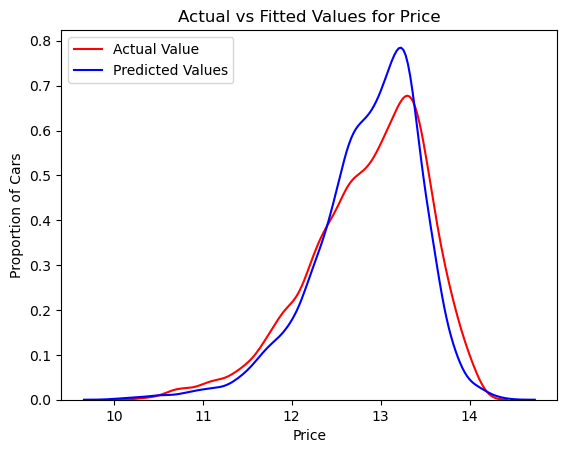

In [557]:
# Create a LinearRegression model
estimator = LinearRegression()

get_model_metrics(estimator,X_train,y_train)

### ***Polynomial Regression***

Training Error: 0.069810926242813
Mean Validation Error: 0.0726925015508574


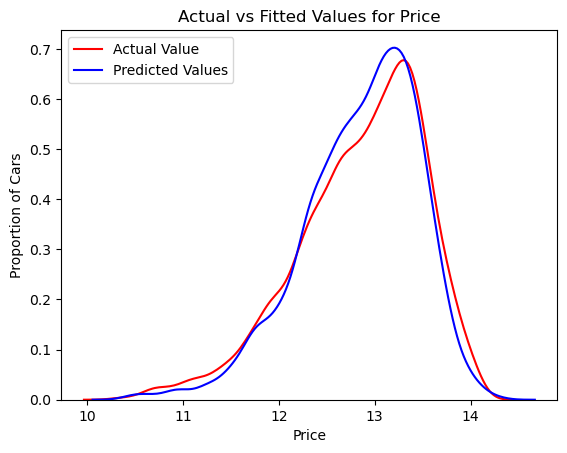

In [558]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
estimator = Ridge(alpha=0.1)

get_model_metrics(estimator,X_train_poly,y_train)

### ***Decision Tree***

Training Error: 0.0012080005283913063
Mean Validation Error: 0.07186594802921623


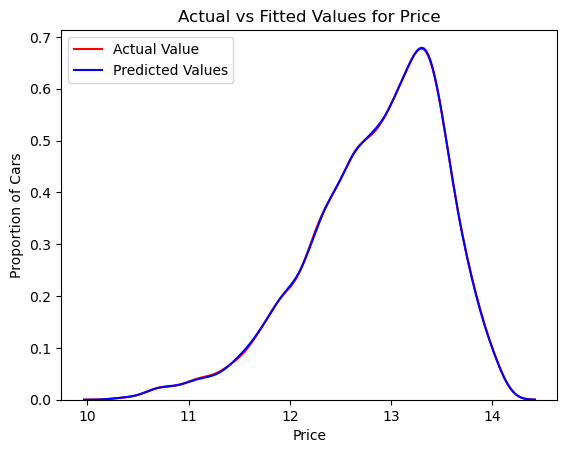

In [559]:
# Create a decision tree regressor
estimator = DecisionTreeRegressor()

get_model_metrics(estimator,X_train,y_train)

### ***Random forrest***

Training Error: 0.0064999486586704855
Mean Validation Error: 0.04284908499806857


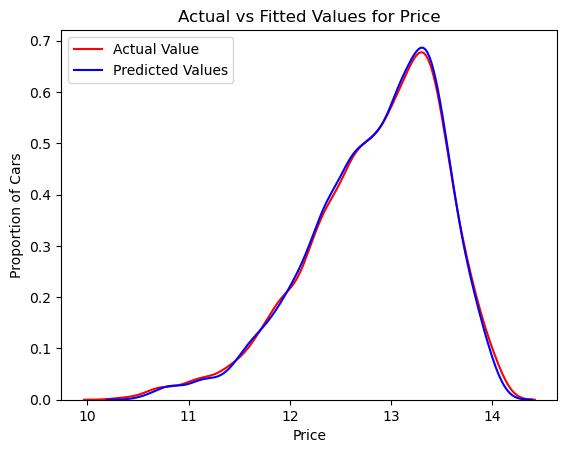

In [560]:
# Create a Random Forest regressor
estimator = RandomForestRegressor()

get_model_metrics(estimator,X_train,y_train)

### ***Support Vector Regressor (SVR)***

Training Error: 0.07178390710861002
Mean Validation Error: 0.07485331576540222


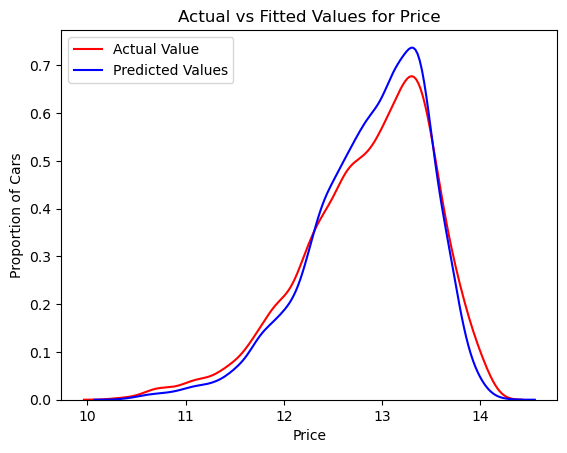

In [561]:
# Create an SVR regressor
estimator = SVR()

get_model_metrics(estimator,X_train,y_train)

Based on the results, the Decision Tree and Random Forest models appear to have overfitted the data, as indicated by significantly lower training errors compared to the mean validation errors. The SVR model stands out with a relatively low mean validation error, making it a suitable choice as it balances model complexity and performance.

## ***Hyperparameters fine tuning***

For SVR, the available hyperparameters that you can tune are:
* Kernel: The kernel function
* epsilon: The epsilon parameter

In [562]:
# Define the estimator
estimator = SVR()

# Define the hyperparameter distribution
param_dist = {
    'kernel': ['linear', 'poly', 'rbf'],
    'epsilon': [0.1, 0.2, 0.3]
}

scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Perform randomized search
random_search = GridSearchCV(estimator, param_dist,  scoring=scoring, cv=5)
random_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Print the results
print("Best Parameters:", best_params)
print("Best Mean Validation Error:", -random_search.best_score_)

Best Parameters: {'epsilon': 0.1, 'kernel': 'poly'}
Best Mean Validation Error: 0.07405693189655618


Training Error: 0.07060303320572313
Mean Validation Error: 0.07405693189655618


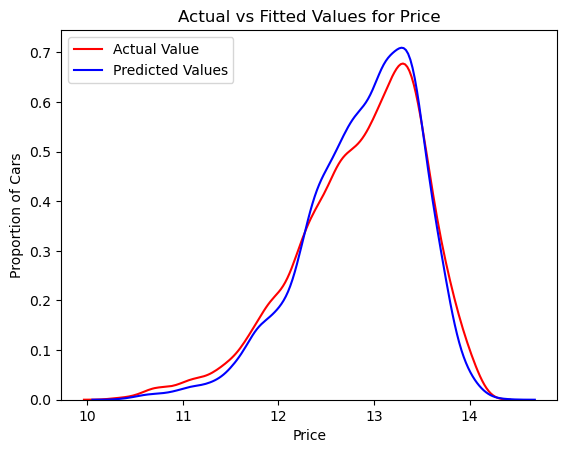

In [563]:
svr_model = SVR(kernel=best_params['kernel'],epsilon = best_params['epsilon'])

get_model_metrics(svr_model,X_train,y_train)

# ***Testing Model***

In [564]:
X_test , y_test = prepare_data_for_model(testing_data,one_hot_encoder)

In [565]:
# inverse-transform values that were previously logarithmically transformed
def inverse_transform(log_transformed_values):
    return np.exp(log_transformed_values)

In [566]:
# Make predictions on the training data
y_test_pred = svr_model.predict(X_test)

# Apply inverse transformation
y_test_pred_inversed = inverse_transform(y_test_pred)
y_test_transformed = np.log(y_test)

# Calculate the training error
test_error = mean_squared_error(y_test_transformed, y_test_pred)

# Print the error
print("Testing Error:", test_error)

Testing Error: 0.16583797319632698


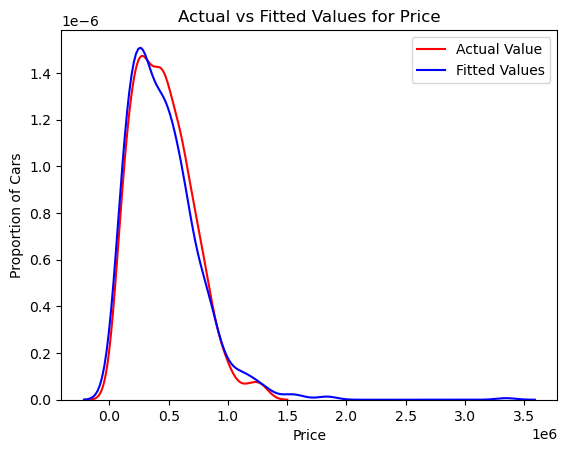

In [567]:
# Create the subplot
fig, ax1 = plt.subplots()

# Plot the actual values
sns.kdeplot(y_test, color="r", label="Actual Value")

# Plot the fitted values
sns.kdeplot(y_test_pred_inversed, color="b", label="Fitted Values", ax=ax1)

# Set title and labels
plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')
plt.legend()

# Display the plot
plt.show()

It is expected that the testing error would be higher than the validation error, and this increase is generally accepted in machine learning. Since the testing data represents unseen instances, it poses a greater challenge for the model compared to the validation data. Despite the increase, as long as the testing error remains within a limited range and the model's overall performance on unseen data is still satisfactory, it is considered acceptable. 